Part 1：图像处理——图像修复（Restoration）
======================================


# 图像修复（复原）
&emsp;&emsp;以某种预定方式改进图像，与图像增强不同，图像复原利用**退化（Degradation）**现象的先验知识，建模退化过程并应用**逆过程**对退化图像 $g(x,y)$ 进行修复，得到原图像 $f(x,y)$ 的一个估计 $\hat{f}(x,y)$。

* 对修复过程进行建模：
![pic](../yunlab/week2/pics/restoration_model.png "model")

* 退化图像：
$$
g(x,y) = (h\otimes f)(x,y) + \eta(x,y)  \\
\otimes —— 卷积运算
$$

* 频率域等效公式：
$$
G(u,v) = H(u,v)F(u,v) + N(u,v)
$$

## 主要六种噪声类型：
![pic](../yunlab/week2/pics/noise_type.png "noise types")

* 噪声性质有两类：**加性噪声**与信号无关，本身存在；**乘性噪声**一般由信道引起，与信号相乘，可以通过傅里叶变换转换成加性。
* 噪声来源：传感器、光照环境、信号传输过程、图像处理过程。

* 高斯（Gaussian）:  实际的系统中不存在，但可以很好地对各种噪声进行**模拟**，方便数学计算。
$$
\begin{equation}
p(z) = \frac{1}{\sqrt{2\pi}\sigma}e^{-(z-\bar{z})^2/2\sigma^2}, -\infty < z < \infty
\end{equation}
\tag{1}
$$  
  
  
* 瑞利（Reyleigh）:  对设备噪声的模拟具有较好效果。
$$
\begin{equation}
p(z) = 
\left\{
\begin{array}{}
\frac{2}{b} (z - a)e^{-(z - a)^2 \over b}\quad &z \ge a
\\
0\quad &z \le a
\end{array}
\right. 
\\
\bar{z} = a + \sqrt{\pi b \over 4}, \quad
\sigma^2 = \frac{b(4 - \pi)}{4}
\end{equation}
\tag{2}
$$  

* 爱尔兰 / 伽马（Erlang / Gamma）：
$$
\begin{equation}
p(z) = 
\left\{
\begin{array}{}
\frac{a^bz^{b-1}}{(b-1)!} e^{-az}\quad &z \ge 0
\\
0\quad &z \lt 0
\end{array}
\right. 
\\
\bar{z} = \frac{b}{a}, \quad
\sigma^2 = \frac{b}{a^2}
\end{equation}
\tag{3}
$$  


* 指数（Exponential）:  不对称，不存在负噪声。
$$
\begin{equation}
p(z) = 
\left\{
\begin{array}{}
ae^{-az} \quad &z \ge 0
\\
0 \quad &z \lt 0
\end{array}
\right. 
\\
\bar{z} = a + \sqrt{\pi b \over 4}, \quad
\sigma^2 = \frac{b(4 - \pi)}{4}
\end{equation}
\tag{4}
$$  
  
  
* 均匀（Uniform）:  设备量化采样时取中间值，可以作为量化过程的噪声模型。一般来自设备以及对图片的操作。
$$
\begin{equation}
p(z)  =
\left\{
\begin{array}{}
\frac{1}{b - a} \quad & a \le z \le b
\\
0 \quad & other
\end{array}
\right.
\\
\bar{z} = \frac{a+b}{2}, \quad
\sigma^2 = 0
\end{equation}
\tag{5}
$$


* 脉冲 / 椒盐（Impulse / Pepper & Salt）：黑白相间的亮暗点噪声。
$$
\begin{equation}
p(z)  =
\left\{
\begin{array}{}
P_s \quad & z = 2^k - 1
\\
P_p \quad & z = 0
\\
1 - (P_s+P_p) \quad & z = V
\end{array}
\right.
\\
\bar{z} = (0)P_p + K(1 - P_s - P_p) + (2^k - 1)P_s
\\
\sigma^2 = (0 - \bar{z})^2P_p + (K - \bar{z})^2(1 - P_s - P_p) + (2^k - 1)^2P_s
\end{equation}
\tag{5}
$$


In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


picCount = 0


def show(src, til) -> None:
    global picCount
    picCount += 1
    
    plt.figure(picCount, (15, 30))
    plt.imshow(src, 'gray'), plt.axis('off'), plt.title(til)
    plt.show()

    plt.hist(src.ravel(), 256, [0, 256])
    plt.show()


# 添加高斯噪声
def gaussian_noise(src, mean, sigma):
    dst = src / 255
    sigma /= 255
    noise = np.random.normal(mean, sigma, src.shape)
    dst += noise
    dst = np.clip(dst, 0, 1)  # 归一化
    dst = np.uint8(dst * 255)  # 还原成灰度图
    return dst


# 添加指数噪声
def exponential_noise(src, scale = 1.0):
    dst = src.copy()
    noise = np.random.exponential(scale, dst.shape)
    dst += noise.astype(dst.dtype)
    dst = np.uint8(np.clip(dst, 0, 255))
    return dst


# 添加均衡噪声
def uniform_noise(src, mean = 0, sigma = 0):
    dst = src.copy()
    a = 2 * mean - np.sqrt(12 * sigma)
    b = 2 * mean + np.sqrt(12 * sigma)
    noise = np.random.uniform(a, b, dst.shape)
    dst += noise.astype(dst.dtype)
    dst = np.uint8(np.clip(dst, 0, 255))
    return dst


# 添加椒盐噪声
def peppernsalt_noise(src, ps = 0, pp = 0):
    dst = src.copy()
    mask = np.random.choice((0, 0.5, 1), size=dst.shape[:2], p=[pp, (1 - ps - pp), ps])
    dst[mask==1] = 255
    dst[mask==0] = 0
    return dst



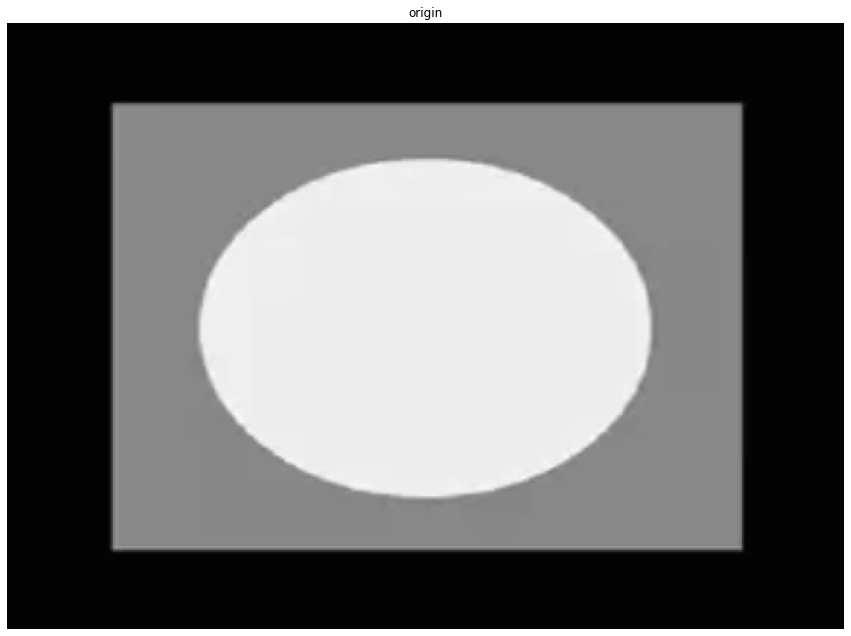

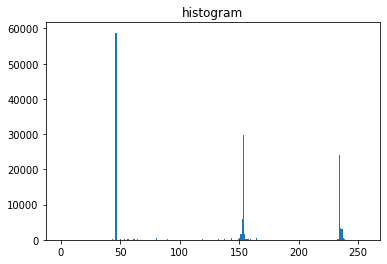

In [58]:
# 原图
three_gray = cv2.imread("pics/three_gray.png", cv2.IMREAD_GRAYSCALE)
show_hist(three_gray, 'origin')

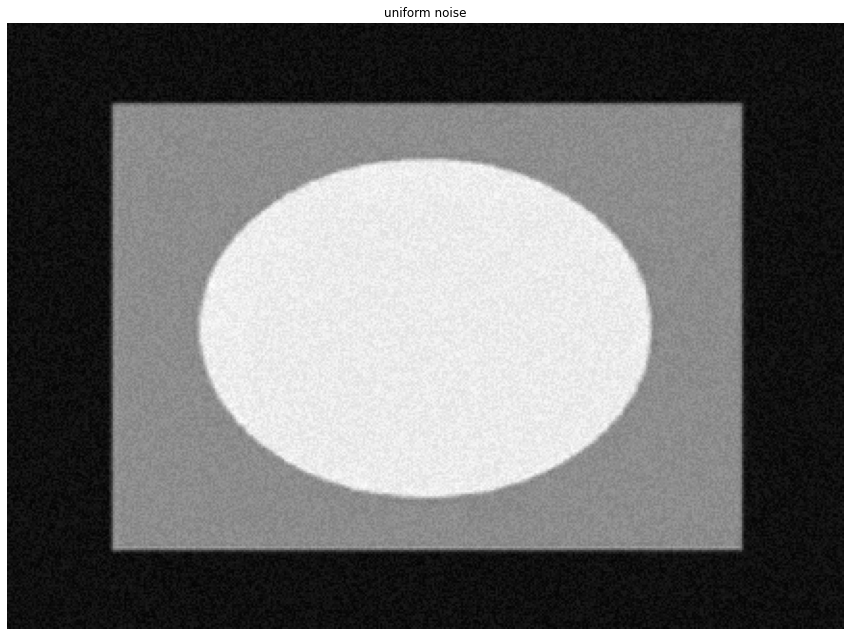

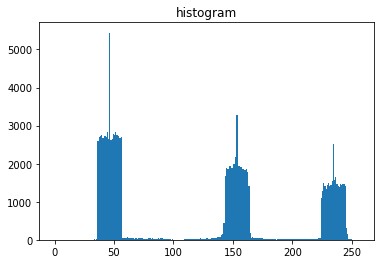

In [59]:
# 均匀噪声
three_gray_uniform = uniform_noise(three_gray, 0, 10)
show_hist(three_gray_uniform, "uniform noise")

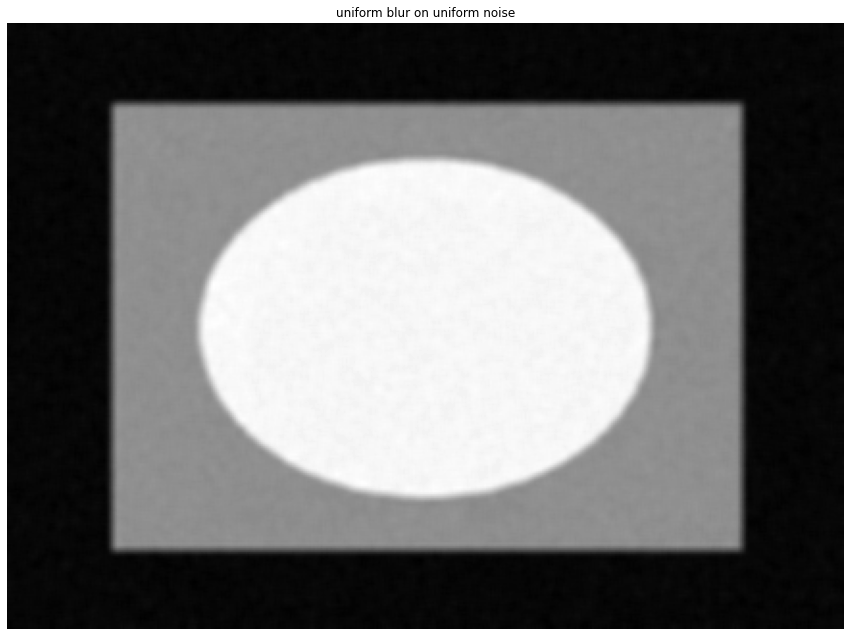

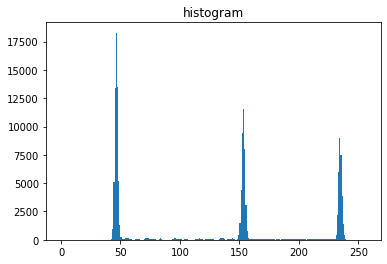

In [60]:
# 对均匀噪声均匀滤波
uniform_blur_on_uniform = cv2.blur(three_gray_uniform, (5,5))
show_hist(uniform_blur_on_uniform, "uniform blur on uniform noise")

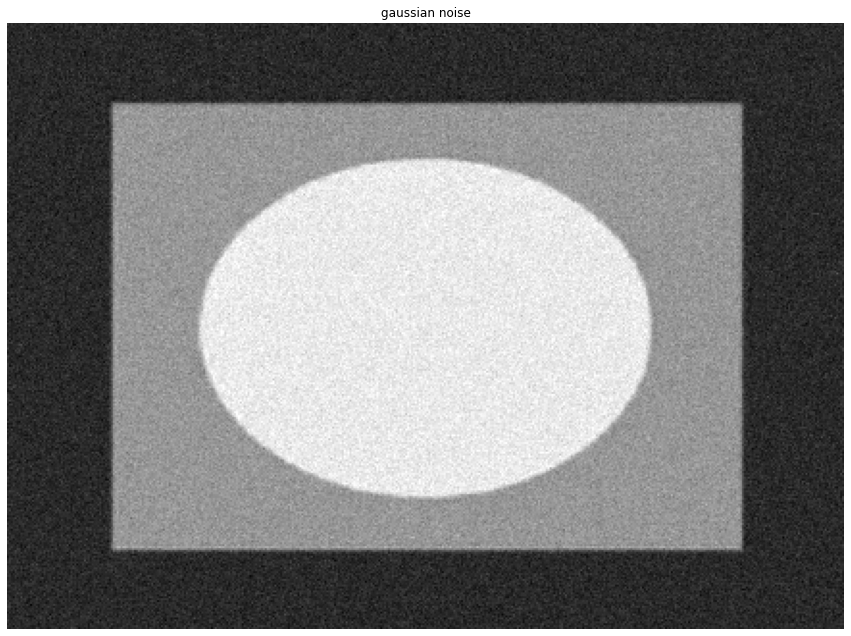

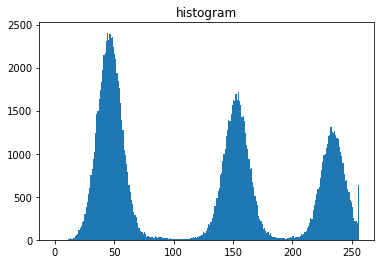

In [61]:
# 高斯噪声
three_gray_gaussian = gaussian_noise(three_gray, 0, 10)
show_hist(three_gray_gaussian, "gaussian noise")

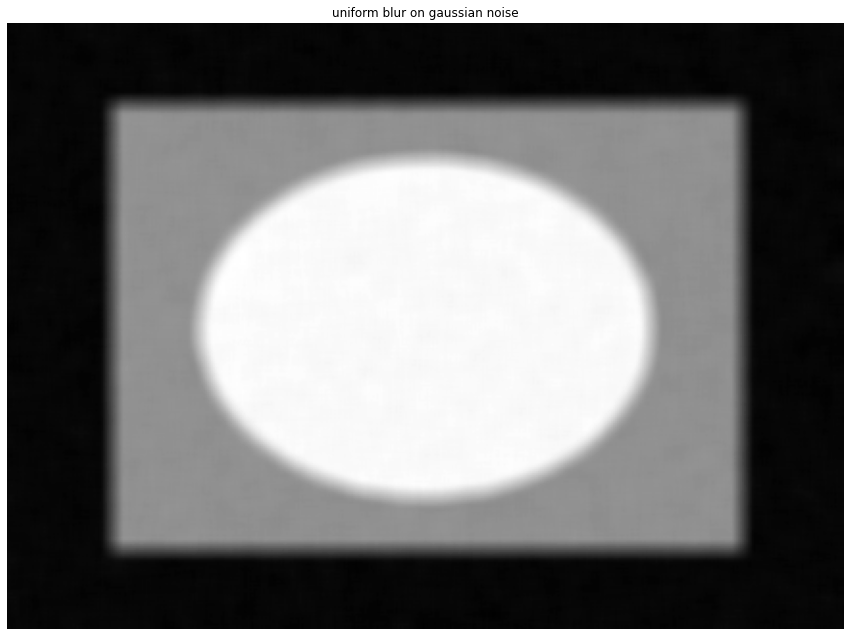

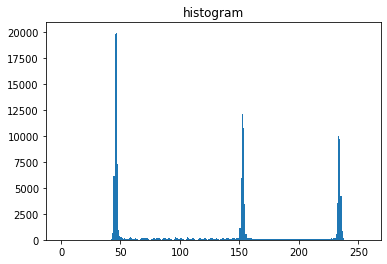

In [62]:
# 对高斯噪声均匀滤波
uniform_blur_on_gaussian = cv2.blur(three_gray_gaussian, (11,11))
show_hist(uniform_blur_on_gaussian, "uniform blur on gaussian noise")

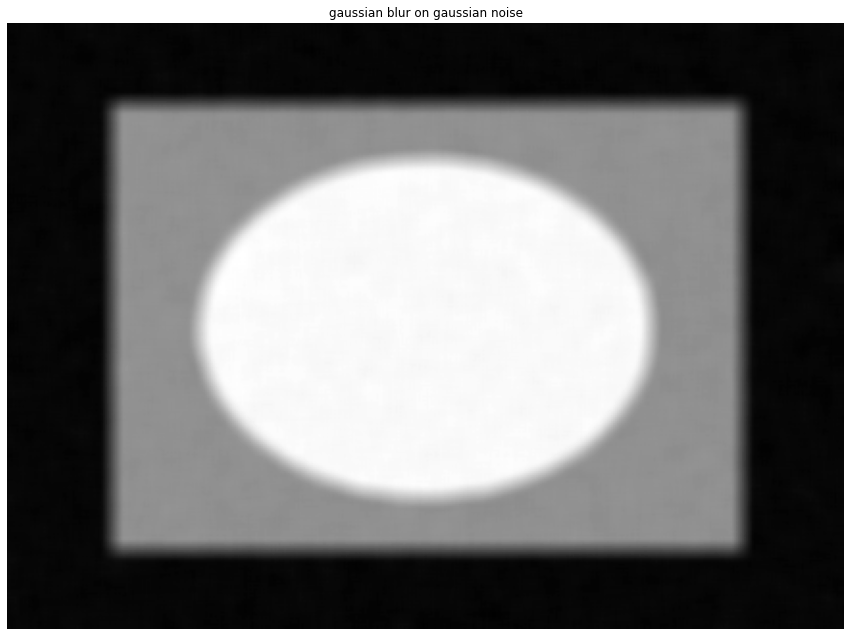

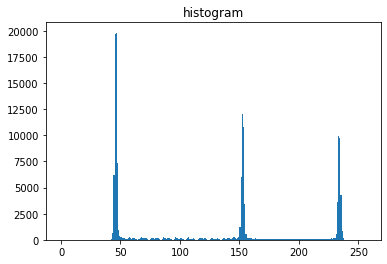

In [63]:
# 对高斯噪声高斯滤波
gaussian_blur = cv2.GaussianBlur(three_gray_gaussian, (11,11), 10)
show_hist(gaussian_blur, "gaussian blur on gaussian noise")

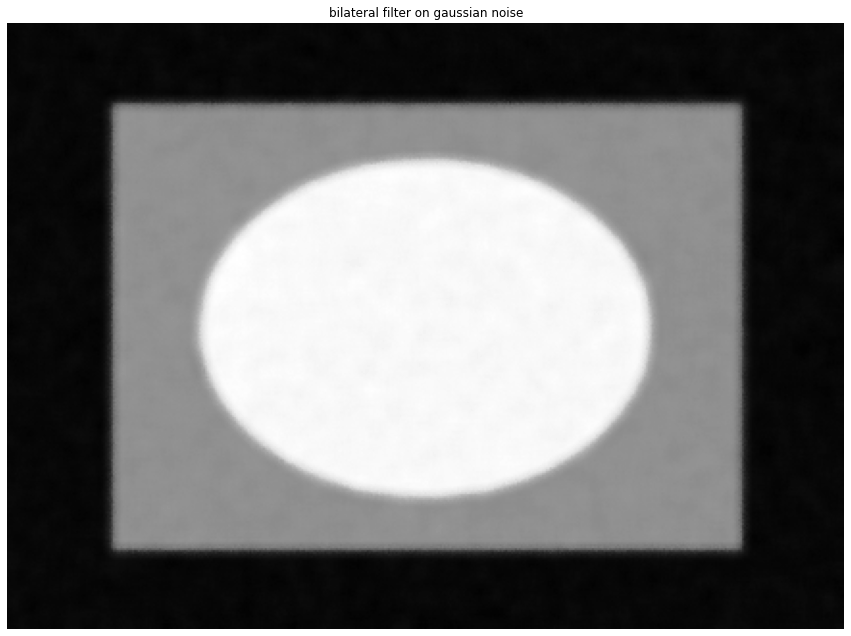

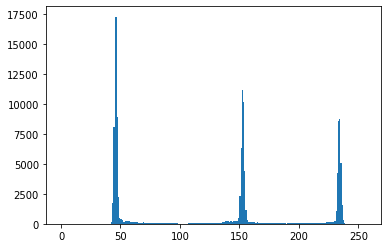

In [75]:
# 对高斯噪声双边滤波：同时使用空间高斯权重和灰度值相似性高斯权重
bilateral_blur = cv2.bilateralFilter(three_gray_gaussian, 11, 75, 75)
show(bilateral_blur, "bilateral filter on gaussian noise")

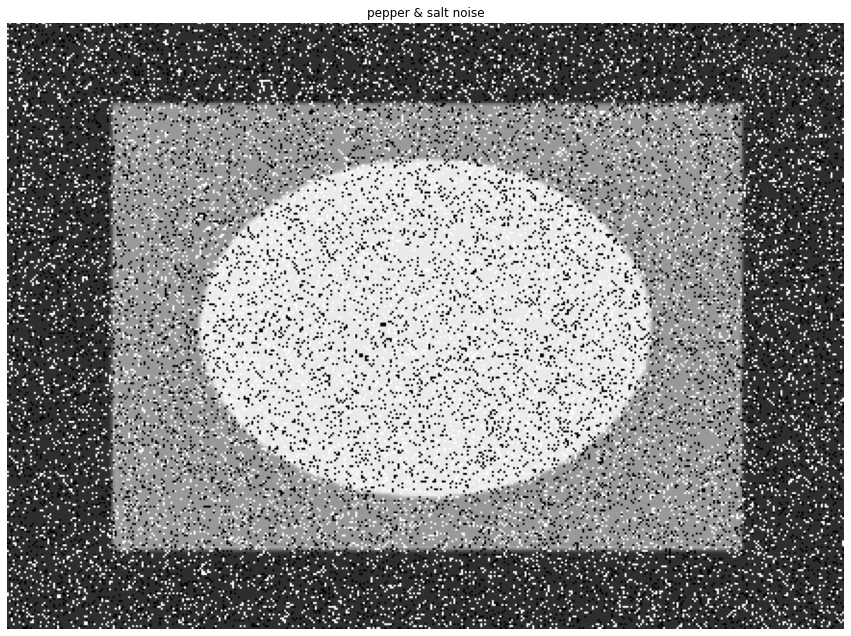

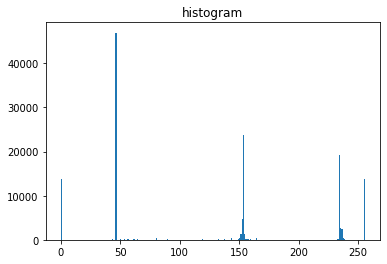

In [65]:
# 椒盐噪声
three_gray_pns = peppernsalt_noise(three_gray, 0.1, 0.1)
show(three_gray_pns, "pepper & salt noise")

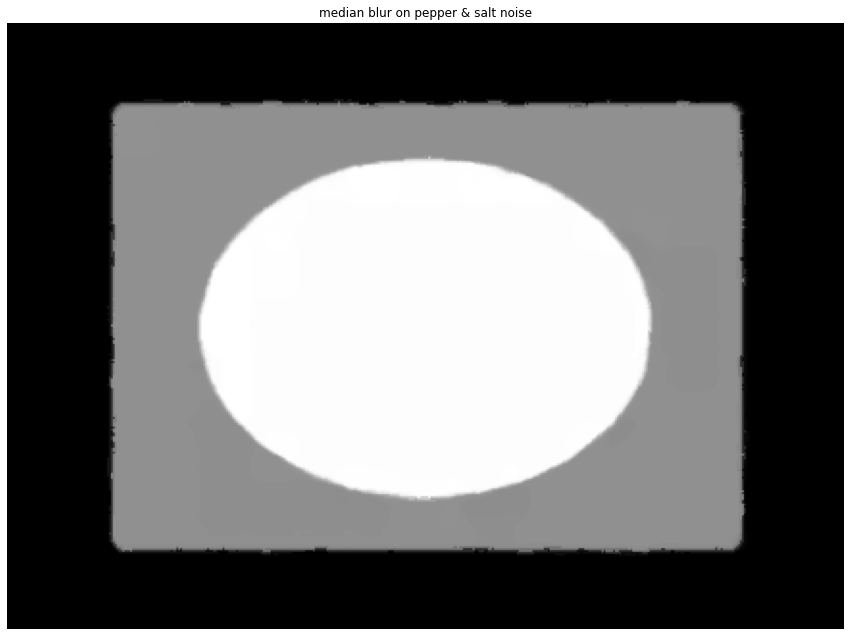

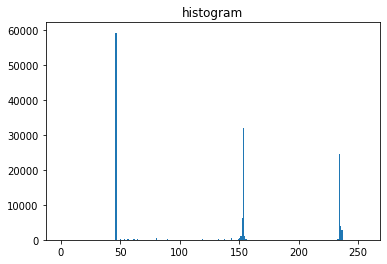

In [76]:
# 对椒盐噪声中值滤波
median_blur = cv2.medianBlur(three_gray_pns, 11)
show_hist(median_blur, "median blur on pepper & salt noise")